# Chapter 19 Classification Models and Evaluation
# Use Case: Credit Risk - Identifying Bad Credit Risks
# ===========================================

Dataset: Credit risk https://datahub.io/machine-learning/credit-g
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [73]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

# package for navigating the operating system
import os

In [74]:
loc = "credit-g.csv"
start_time = time.time()
df = pd.read_csv(loc)
print("It took %s seconds to load the .xlsx file." % (time.time() - start_time))

It took 0.008002996444702148 seconds to load the .xlsx file.


Data Wrangling ... one hot encodings, type conversion

In [75]:
# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")

# one hot encodings
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine Dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function, to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... Make sure type is good. We change the type from str to numeric here, and any 
#df['Installs'] = pd.to_numeric(df['Installs'], errors ='coerce').fillna(0).astype('int')
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,class,checking_status_0<=X<200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,2,22,1,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,4,40,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,4,23,1,1,1,1,0,...,0,1,0,0,0,1,0,0,0,1


## Problem: Imbalanced dataset

Imbalances in datasets for classification problems are a big issue. We generally need to balance the dataset to contain an equal proportion of the different classes before training (and testing). For the credit use-case, we have two classes {1,0}, meaning that ideally we shulld have 50% of training samples as class=1; and 50% as class=0. This can be done by up-sampling the minority class, or downsampling the majority class.
Let us first examine the dataset to determine whether it is in balance.

Imbalanced dataset....
0    700
1    300
Name: class, dtype: int64


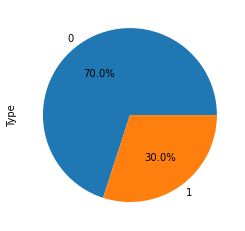

In [90]:

#Pie chart of imbalances wrapped as a func as we will use it a few times..
def pie_of_imbalance(df: pd.DataFrame, class_col: str = 'class'):
    print('Imbalanced dataset....')
    print(df[class_col].value_counts())
    df.groupby(class_col).size().plot(kind='pie', y = 'class', label = "Type",  autopct='%1.1f%%')
    
#run func
pie_of_imbalance(df)

Dataset is not balanced. 70% of samples are class=0; only 30% are class=1. We should bring this into balance before we traing out model, or else risk introducing dangerous biases into our model.

### NB: Separate Training and Testing Sets BEFORE Balancing the Dataset

Before we start up or down-sampling we first we need to create our test and train datasets. This is to keep the training set in-sample and the testing set strictly out of sample (ie our learner does not see any of the test samples until we run the test). If we fail to do this before upsampling, we can suffer data-snooping biases (also called leakage), which would invalidate our model.

In [91]:
# Define X and y variables
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

### RandomForest Classifier
We will use the RandomForest classifier to help us test different up and down sampling approaches to deal with the imbalanced dataset

Get the sklearn packages we will need for our clasification problem

In [92]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# CLassifiers
from sklearn.ensemble import RandomForestClassifier


# metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

We can wrap this classifier, and the performance metrics we will get from it in a function

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.7957, test:  0.7133
Precision train: 0.7774, test:  0.7097
Recall train: 0.9980, test:  0.9754
F1 train: 0.4604, test:  0.2712


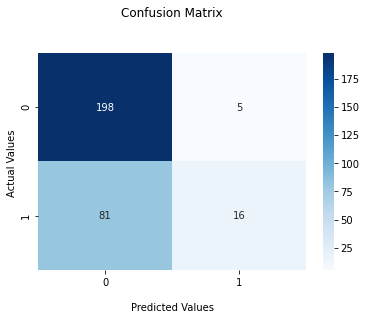

In [93]:
# Declare a function to wrap training of a classifier and printing of performance data
def run_rf_classification_models(X_train: pd.DataFrame, X_test: pd.DataFrame, 
                            y_train: pd.DataFrame, y_test: pd.DataFrame) -> list:

    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_train) # scale both sets:
    X_test = sclr.fit_transform(X_test)

    # classifier train
    rf = RandomForestClassifier(max_depth=5,random_state=0)
    rf.fit(X_train,y_train)
    y_train_hat =rf.predict(X_train)
    y_test_hat = rf.predict(X_test)

    # Print score
    print(type(rf))        
    print(f"Accuracy train: {rf.score(X_train,y_train):.4f}, test: ",
      f"{rf.score(X_test,y_test):.4f}")
    print(f"Precision train: {precision_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{precision_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{recall_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
      f"{f1_score(y_test,y_test_hat, average=None)[1]:.4f}")
    #print(f1_score(y_test, y_test_hat, average=None))


    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

#run rf classifier
run_rf_classification_models(X_train, X_test, y_train, y_test)

## Test the performance of different up, and down sampling approaches

### 1) Upsampling using resampling

Now we can test Up-sampling using Resample, and examine how well it does using the RandomForest classifier on our problem

In [94]:
from sklearn.utils import resample

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Create up-sampled data set for minority class
# note that n_samples= the number of samples the imbalance represents.
X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=(X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0]),
                                        random_state=None)

#Combine train with upsampled
X_upsampled = X_train.append(X_upsampled)
y_upsampled = y_train.append(y_upsampled)

Lets check everything is in balance now

Imbalanced dataset....
1    507
0    507
Name: class, dtype: int64


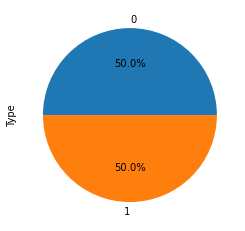

In [95]:
#get pie of the current imbalance
temp = pd.concat([X_upsampled, y_upsampled], axis=1)
pie_of_imbalance(temp)

Dataset is perfectly in balance...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8195, test:  0.7200
Precision train: 0.8447, test:  0.8263
Recall train: 0.7830, test:  0.7150
F1 train: 0.8259, test:  0.6500


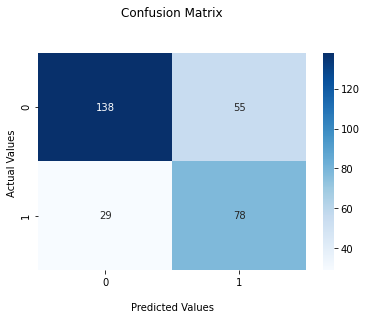

In [96]:
#Run our function....
all_models = run_rf_classification_models(X_upsampled, X_test, y_upsampled, y_test)

F1s for the different learners have changed, some improved and some not.
We can try SMOTE for upsampling now, a more sophisticated approach...

### 2) Up-sampling using a synthetic over sampling approach called SMOTE

In [97]:
from imblearn.over_sampling import SMOTE

#How many samples do we need to balance?
idx = np.random.choice(X_train.shape[0], size=X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0], replace=False)

# Generate SMOTE samples and use this to train
upsampler_smote = SMOTE()
X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

Let us examine the distribution of the synthetic datapoint that SMOTE creates

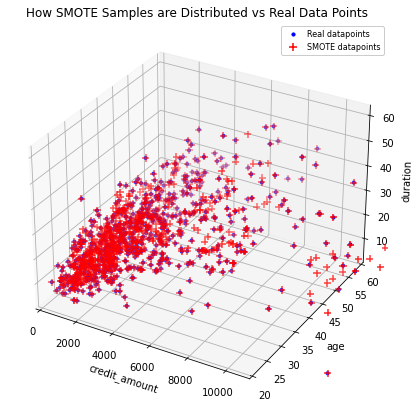

In [98]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['credit_amount'],X_train['age'], X_train['duration'], marker="o", s=10, c='blue', label='Real datapoints')
ax.scatter(X_upsampled_smote['credit_amount'],X_upsampled_smote['age'], X_upsampled_smote['duration'], marker="+", s=50, c='red', label='SMOTE datapoints')

# set axes range
plt.xlim(0, 11000)
plt.ylim(20, 60)

ax.set_xlabel('credit_amount')
ax.set_ylabel('age')
ax.set_zlabel('duration')

plt.title('How SMOTE Samples are Distributed vs Real Data Points')
plt.legend(loc=1,framealpha=1, fontsize=8)
plt.show()

The synthetic datapoints look realistic at a glance.

Imbalanced dataset....
1    507
0    507
Name: class, dtype: int64


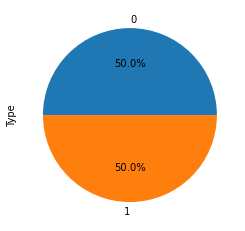

In [99]:
#get pie of the current imbalance
temp = pd.concat([X_upsampled_smote, y_upsampled_smote], axis=1)
pie_of_imbalance(temp)

Dataset is perfectly in balance...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8708, test:  0.7300
Precision train: 0.8821, test:  0.7828
Recall train: 0.8560, test:  0.8031
F1 train: 0.8727, test:  0.6124


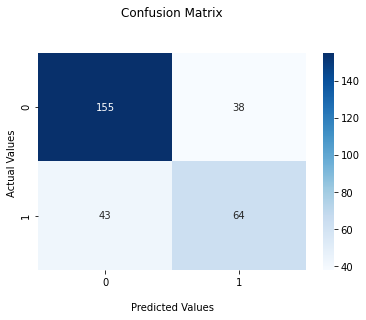

In [100]:
#Run our function....
all_models = run_rf_classification_models(X_upsampled_smote, X_test, y_upsampled_smote, y_test)

### 3. Down-sampling

Now we can test down-sampling, simply removing samples from the majority class. 

In [101]:
from imblearn.under_sampling import RandomUnderSampler 

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Randomly downsample rows in the majority class
rus = RandomUnderSampler(random_state=42)
X_downsampled, y_downsampled = rus.fit_resample(X_train, y_train)

Imbalanced dataset....
1    215
0    215
Name: class, dtype: int64


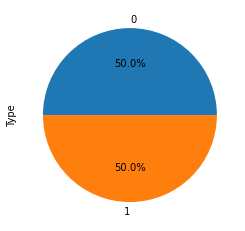

In [102]:
#get pie of the current imbalance
temp = pd.concat([X_downsampled, y_downsampled], axis=1)
pie_of_imbalance(temp)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8326, test:  0.7100
Precision train: 0.8421, test:  0.8951
Recall train: 0.8186, test:  0.6744
F1 train: 0.8349, test:  0.6099


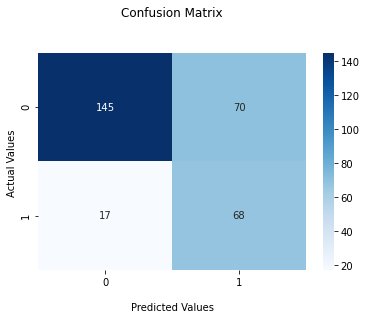

In [103]:
#Run our function....
all_models = run_rf_classification_models(X_downsampled, X_test, y_downsampled, y_test)